# Sinkhorn iteration for optimal transport with Tensorflow

In [1]:
import numpy as np
import pylab as pl
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import cv2
from IPython.display import clear_output

from lucid.misc.io import showing as show

import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

import tensorflow as tf
tf.enable_eager_execution()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1662976/45929032 bytes (3.6%)5251072/45929032 bytes (11.4%)8970240/45929032 bytes (19.5%)12820480/45929032 bytes (27.9%)16310272/45929032 bytes (35.5%)20078592/45929032 bytes (43.7%)23887872/45929032 bytes (52.0%)27672576/45929032 bytes (60.3%)31481856/45929032 bytes (68.5%)35348480/45929032 bytes (77.0%)39133184/45929032 bytes (85.2%)42868736/45929032 bytes (93.3%)

In [0]:
def gen_points(s, font_size=42):
  font = PIL.ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', font_size)
  w, h = font.getsize(s)
  im = PIL.Image.new('L', (w, h))
  draw  = PIL.ImageDraw.Draw(im)
  draw.text((0, 0), s, fill=255, font=font)
  im = np.uint8(im)
  y, x = np.float32(im.nonzero())
  pos = np.column_stack([x, y])
  if len(pos) > 0:
    pos -= (w/2, h/2)
    pos /= font_size
  return pos


In [0]:
# along the lines of
# https://nbviewer.jupyter.org/github/gpeyre/numerical-tours/blob/master/python/optimaltransp_6_entropic_adv.ipynb

@tf.function
def pdist(x, y):
  dx = x[:, None, :] - y[None, :, :]
  return tf.reduce_sum(tf.square(dx), -1)

@tf.function
def Sinkhorn_step(C, f):
  g = tf.reduce_logsumexp(-f-tf.transpose(C), -1)
  f = tf.reduce_logsumexp(-g-C, -1)
  return f, g

def Sinkhorn(C, f=None, niter=1000):
  n = tf.shape(C)[0]
  if f is None:
    f = tf.zeros(n, np.float32)
  for i in range(niter):
    f, g = Sinkhorn_step(C, f)
  P = tf.exp(-f[:,None]-g[None,:]-C)/tf.cast(n, tf.float32)
  return P, f, g


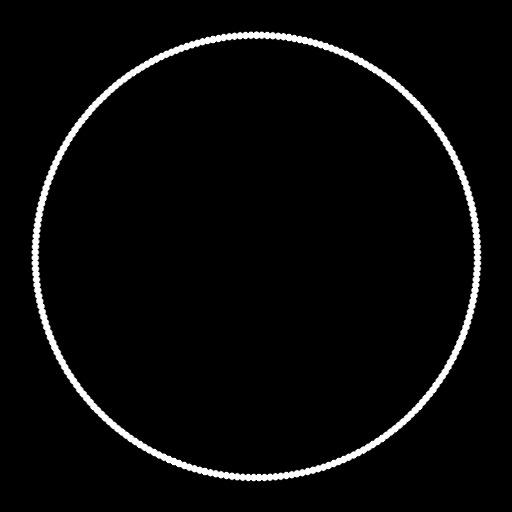

In [14]:
VIDEO_SIZE = 512

def draw_points(p):
  w = VIDEO_SIZE
  img = np.zeros((w, w, 3), np.uint8)
  #img[:] = 255
  p = np.int32((w/2+p*w*0.9)*4)
  for x, y in p:
    cv2.circle(img, (x, y), 12, (255, 255, 255), -1, cv2.CV_AA, shift=2)
  return img

t = np.linspace(0, 2*np.pi, 256)
x = 16*np.sin(t)
y = 16*np.cos(t)
pos0 = np.float32(np.column_stack([x*0.03, -y*0.03]))

show.image(draw_points(pos0)/255.0)


In [15]:
pos = pos0.copy()

with FFMPEG_VideoWriter('out.mp4', (VIDEO_SIZE, VIDEO_SIZE), 60.0) as video:
  video.write_frame(draw_points(pos))
  f = None
  for s in 'RING ':
    target = gen_points(s) if s != ' ' else pos0
    for i in range(80):
      C = pdist(pos, target)/(0.01)**2
      P, f, g = Sinkhorn(C, f=f, niter=20)
      P = P.numpy()
      g = P.dot(target)*len(pos)-pos
      pos += 0.1*g
      frame = draw_points(pos)
      video.write_frame(frame)
    print(s, end='', flush=True)

    

RING 

In [16]:
mvp.ipython_display('out.mp4', loop=True)